# **Real time Mask Detection Using Deep Learning**








In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
cd 'gdrive/My Drive/Covid 19 mask detector/face-mask-detector'

/content/gdrive/My Drive/Covid 19 mask detector/face-mask-detector


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from keras.applications import ResNet50
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from PIL import Image
import numpy as np
import flask
import io
import tensorflow as tf
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from imutils.video import WebcamVideoStream
import time
import cv2
import imutils

%matplotlib inline

In [0]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

In [0]:
i=1
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	name = imagePath.split(os.path.sep)[-1]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	i = i+1
	print(name,i)
	data.append(image)
	labels.append(label)
data = np.array(data)

345.jpg 2
augmented_image_144.jpg 3
378.jpg 4
augmented_image_156.jpg 5
augmented_image_163.jpg 6
augmented_image_133.jpg 7
179.jpg 8
31.jpg 9
47.jpg 10
214.jpg 11
augmented_image_136.jpg 12
augmented_image_55.jpg 13
69.jpg 14
augmented_image_239.jpg 15
augmented_image_140.jpg 16
augmented_image_187.jpg 17
augmented_image_126.jpg 18
augmented_image_58.jpg 19
276.jpg 20
310.jpg 21
133.jpg 22
250.jpg 23
augmented_image_235.jpg 24
312.jpg 25
92.jpg 26
augmented_image_308.jpg 27
augmented_image_208.jpg 28
9.jpg 29
437.jpg 30
203.jpg 31
augmented_image_94.jpg 32
213.jpg 33
220.jpg 34
augmented_image_107.jpg 35
19 (1).jpg 36
229.jpg 37
4.jpg 38
augmented_image_162.jpg 39
augmented_image_158.jpg 40
augmented_image_252.jpg 41
27.jpg 42
131.jpg 43
477.jpg 44
261.jpg 45
59.jpg 46
414.jpg 47
221.jpg 48
augmented_image_207.jpg 49
392.jpg 50
54.jpg 51
augmented_image_200.jpg 52
augmented_image_169.jpg 53
93.jpg 54
augmented_image_276.jpg 55
143.jpg 56
125.jpg 57
421.jpg 58
88.jpg 59
109.jpg 60
99.j

In [0]:
data.shape

(0,)

In [0]:
#labels = list(i.split(sep = '/')[1] for i in imagePaths)
#x = np.array(labels)
#x = x.reshape(-1,1)
#data = list(plt.imread(i) for i in imagePaths)

#i=1
#rows = 4
#columns = 4
#fig = plt.figure()
#for item in data:
#  fig.add_subplot(4,4,i)
#  plt.imshow(item)
#  i = i+1
#  if i >16:
#    break
#plt.show()

In [0]:
# to one hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
# partition
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [0]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [0]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
37/37 [==============================] - 16s 443ms/step - loss: 0.5263 - accuracy: 0.7509 - val_loss: 0.1360 - val_accuracy: 0.9633
Epoch 2/20
37/37 [==============================] - 15s 393ms/step - loss: 0.1452 - accuracy: 0.9512 - val_loss: 0.0554 - val_accuracy: 0.9967
Epoch 3/20
37/37 [==============================] - 15s 393ms/step - loss: 0.0950 - accuracy: 0.9675 - val_loss: 0.0368 - val_accuracy: 0.9967
Epoch 4/20
37/37 [==============================] - 15s 407ms/step - loss: 0.0737 - accuracy: 0.9738 - val_loss: 0.0278 - val_accuracy: 0.9967
Epoch 5/20
37/37 [==============================] - 14s 390ms/step - loss: 0.0590 - accuracy: 0.9854 - val_loss: 0.0223 - val_accuracy: 0.9967
Epoch 6/20
37/37 [==============================] - 15s 395ms/step - loss: 0.0560 - accuracy: 0.9780 - val_loss: 0.0185 - val_accuracy: 0.9967
Epoch 7/20
37/37 [==============================] - 15s 399ms/step - loss: 0.0400 - accuracy

In [0]:
print("[INFO] saving mask detector model...")
model.save('../model_mask1', save_format="h5")

[INFO] saving mask detector model...


In [0]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       141
without_mask       1.00      1.00      1.00       159

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



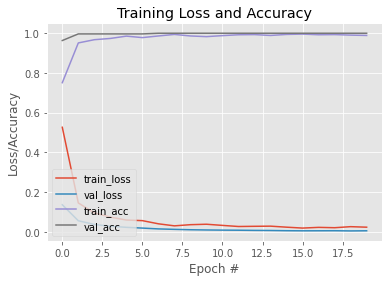

In [0]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [0]:
model.summary()

#Upload the Model and predict on the image

In [0]:
model = load_model('../model_mask')

# Model image

In [0]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(['face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['face_detector',
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model_load = model



[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [0]:
ls

dataset/              examples/            photo.jpg
detect_mask_image.py  face_detector/       plot.png
detect_mask_video.py  mask_detector.model  train_mask_detector.py


[INFO] computing face detections...
Mask: 99.96%
99.95657801628113


-1

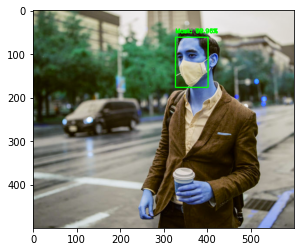

In [0]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('examples/example_01.png')
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()
#detections=net(blob)
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model_load.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	
		print(label)
		# display the label and bounding box rectangle on the output
		# frame
		print(max(mask,withoutMask)*100)
		cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
plt.imshow(image)
cv2.waitKey(0)